In [182]:
import os
import importlib
from functools import cache

import numpy as np
import xarray as xr
import dask

import pandas as pd
import geopandas as gpd


import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt

import matplotlib.colors as colors
from shapely.geometry import Point

import itertools
import matplotlib.mlab as ml
import matplotlib.animation as animation
from matplotlib.ticker import LogFormatter

direc = os.getcwd()
os.chdir("/home/b/b381737/python_scripts/master/open_data")
import open_data_utils #import the module here, so that it can be reloaded.
importlib.reload(open_data_utils)
from open_data_utils import xr_to_gdf, add_country_names, country_intersections, select_extent, FlexDataset, FlexDataCollection
os.chdir(direc)


In [183]:
dir_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20090101-07/test2/grid_conc_20090101000000.nc"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180905/grid_conc_20180905000000.nc"
#file_path = "OD20180905/grid_conc_20180905000000.nc"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20141009-13/hko_mult/grid_time_20141013000000.nc"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180126-20180201/grid_time_20180201210000.nc"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180126-20180201/long/grid_time_20180201210000.nc"
#file_path = "EI20091123-20091207/grid_time_20091207210000.nc"
#file_path = "EI20121123-20121207/grid_time_20121207210000.nc"
file_path = "EI20091123-20091207/pressure_setup/grid_time_20091207210000.nc"
#data = xr.open_dataset(dir_path + file_path, chunks=dict(time=15, pointspec=4))


In [184]:
fd = FlexDataset(dir_path + file_path, extent=[100,180,-60,0], chunks=dict(time=15, pointspec=4))

No total footprints found to load. Calculation...
Saving Footprints to /work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20091123-20091207/pressure_setup
Done


In [177]:
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(projection=ccrs.PlateCarree()))
#fd.plot(ax, 0, np.arange(50,100), [1,2,3,4,5,6])
fd.plot_footprint(ax, 0, cmap="Reds", cbar_kwargs=dict(label="lalla"), plot_station=True)
fd.plot_footprint(ax, 1, cmap="Blues", cbar_kwargs=dict(label="lalla"), plot_station=True)
fd.add_map(ax)

(<GeoAxesSubplot:title={'center':'height = 100.0 [meters]'}, xlabel='longitude in degree east\n[degrees_east]', ylabel='latitude in degree north\n[degrees_north]'>,
 <cartopy.mpl.gridliner.Gridliner at 0x2b166ae89930>)

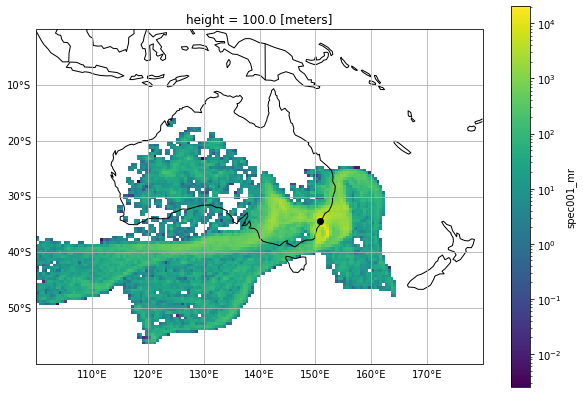

In [179]:
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(projection=ccrs.PlateCarree()))
fc.plot_footprint(ax,1, norm=colors.LogNorm(), plot_station=True)
fc.add_map(ax)


In [ ]:
fc = FlexDataCollection(dir_path + file_path, dir_path + file_path, extent=[100,180,-60,0], chunks=dict(time=15, pointspec=4))

(<GeoAxesSubplot:title={'center':'height = 100.0 [meters]'}, xlabel='longitude in degree east\n[degrees_east]', ylabel='latitude in degree north\n[degrees_north]'>,
 <cartopy.mpl.gridliner.Gridliner at 0x2b1662631450>)

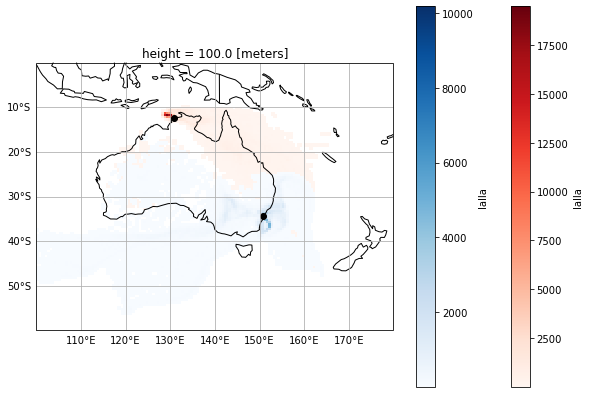

# Assign Country to data and choose

In [34]:
mass = data.spec001_mr[dict(pointspec=[0,1,2])].sum(dim=["time", "pointspec"])[0]
gdf = xr_to_gdf(mass, "spec001_mr")
gdf = add_country_names(gdf)
#gdf.to_pickle("/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20121123-20121207/gdf.pkl")
ci = country_inersections(gdf, "Australia")
#intersections = country_inersections(mass, "Australia")

In [35]:
gdf.to_pickle("/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20121123-20121207/gdf_woll_12.pkl")

In [95]:
columns=["Station","Year","Total [s]", "Australia [%]", "Other countries [%]", "Ocean [%]"]
df = pd.DataFrame(columns=columns)
direc="/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20121123-20121207/"
l = []
for y in ["09", "12"]:
    for stat in ["woll", "dar"]:
    
        l.append("Wollongong" if stat == "woll" else "Darwin")
        l.append("20"+y)
        path = f"gdf_{stat}_{y}.pkl"
        print(path)
        gdf = pd.read_pickle(direc+path)
        ret = country_intersections(gdf, "Australia")
        tot = gdf.spec001_mr.sum()
        l.append(round(tot, 0))
        for key in ret.keys():
            if key == "rest":
                continue
            l.append(round(ret[key].spec001_mr.sum()/tot*100, 2))
        df = df.append(dict(zip(columns,l)), ignore_index=True)
        l = []

gdf_woll_09.pkl
gdf_dar_09.pkl
gdf_woll_12.pkl
gdf_dar_12.pkl


# Animation

In [ ]:
#for vmin
mass = data.spec001_mr.where(data.spec001_mr!=0)
#height index, vmin, vmax for cbar
h_ind = 0
vmin = np.min(mass.isel(pointspec=[0])).values
vmax = np.max(mass.isel(pointspec=[0])).values
print(vmin)
print(vmax)

#box to be shown TODO: prevent error if not standard projection
extent=[0,180,-85,-0]

cmap = "jet"
norm = colors.LogNorm()

fig, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=ccrs.PlateCarree()))

#total number of frames
frames=len(data.time.values)
#milliseconds between frames
interval=100

def index_mod(index):
    return index

def add_to_ax(ax):
    ax.scatter(114.1742, 22.3025,s=200, label="hko", color="yellow", edgecolor="black", marker="*")
    #ax.scatter(16.1469, 49.0845, s=100, label="Power plant", color="red", marker="^")
    return ax

def animate(index):
    ind = index_mod(index)
    ax.clear()
    mass = data.spec001_mr.isel(time=[ind], height=[h_ind], pointspec=[0])
    mass = mass.where(mass!=0)
    if len(fig.axes)==1:
        mass.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, 
                  norm=norm, 
                  transform=ccrs.PlateCarree(), 
                  cbar_kwargs=dict(label="Footprint [s]"))
    else:
        mass.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, 
                  norm=norm, 
                  transform=ccrs.PlateCarree(),
                  add_colorbar=False)
    ax.set_title(data.time.values[ind].astype('datetime64[h]'))
    add_map(ax, extent=extent)
    add_to_ax(ax)

ani = animation.FuncAnimation(fig, animate, frames, interval=interval, blit=False)
ani.save("/mnt/lustre01/pf/b/b381737/python_scripts/master/open_data/animations/australia/wu.gif")

# Compare two datasets

1914299000.0
3.5516213e+18


/home/b/b381737/.conda/envs/plot_env/lib/python3.10/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


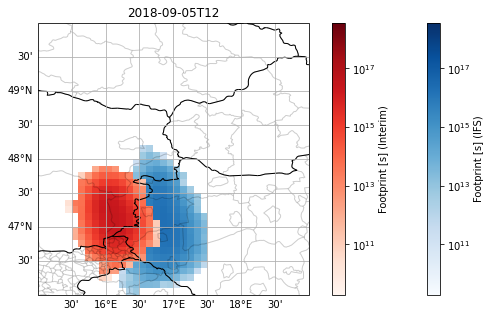

In [26]:
#for vmin
file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/OD20180905/grid_conc_20180905000000.nc"
data1 = xr.open_dataset(file_path)
mass1 = data1.spec001_mr
file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180905/grid_conc_20180905000000.nc"
data2 = xr.open_dataset(file_path)
mass2 = data2.spec001_mr
mass2 = select_extent(mass2, 5, 25, 40, 55)

mass1 = mass1.where(mass1!=0)
mass2 = mass2.where(mass2!=0)



#height index, vmin, vmax for cbar
h_ind = 0
vmin = min([np.min(mass1.isel(pointspec=[0])).values, np.min(mass2.isel(pointspec=[0])).values])
vmax = max([np.max(mass1.isel(pointspec=[0])).values, np.max(mass2.isel(pointspec=[0])).values])
print(vmin)
print(vmax)

#box to be shown TODO: prevent error if not standard projection
extent=[15, 19, 46, 50]

cmaps = ["Blues", "Reds"]
labels = ["Footprint [s] (IFS)", "Footprint [s] (Interim)"]#["Footprint [s] (Interim)", "Footprint [s] (IFS)"]
norm = colors.LogNorm()

fig, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=ccrs.PlateCarree()))

#total number of frames
frames=len(data1.time.values)
#milliseconds between frames
interval=100

def index_mod(index):
    return index

def add_to_ax(ax):
    #ax.scatter(114.1742, 22.3025,s=200, label="hko", color="yellow", edgecolor="black", marker="*")
    #ax.scatter(16.1469, 49.0845, s=100, label="Power plant", color="red", marker="^")
    return ax

def animate(index):
    ind = index_mod(index)
    ax.clear()
    for i, mass in enumerate([mass1,mass2]):
        mass = mass.isel(dict(time=ind, height=0))
        mass = mass.where(mass!=0)
        if len(fig.axes)==(i+1):
            mass.plot(ax=ax, cmap=cmaps[i], vmin=vmin, vmax=vmax, 
                      norm=norm, 
                      transform=ccrs.PlateCarree(), 
                      cbar_kwargs=dict(label=labels[i]))
        else:
            mass.plot(ax=ax, cmap=cmaps[i], vmin=vmin, vmax=vmax, 
                      norm=norm, 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False)
    ax.set_title(data1.time.values[ind].astype('datetime64[h]'))
    add_map(ax, extent=extent)
    add_to_ax(ax)

ani = animation.FuncAnimation(fig, animate, frames, interval=interval, blit=False)
ani.save("/mnt/lustre01/pf/b/b381737/python_scripts/master/open_data/animations/tutorial/vienna_comparision2.gif")